# Modèle de classification de bières
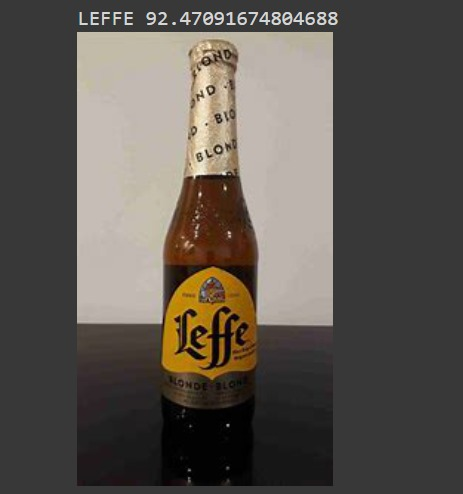

Ce notebook permet de générer différents jeux de données selon les configurations souhaitées (section 1), ainsi que d'entraîner et d'évaluer le modèle de classification (section 2).

## Section 1 : Preprocessing des données

In [2]:
import pandas as pd
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Centrale/Beerbino

Mounted at /content/drive


#### Transformation des dossiers de stockage des images pour faire apparaitre leur label

In [5]:
#On lit le csv issu du scraping contenant les labels des images
bieres = pd.read_csv("scraping/data_beers.csv",sep=";")
bieres.columns = ['unique_id','index_scrapping','link_photo','name','brand','type','website','price']
bieres.drop("unique_id", inplace=True, axis=1)
bieres.rename_axis(index="unique_index", axis=1)

,index_scrapping,link_photo,name,brand,type,website,price
unique_index,,,,,,,
0,0,https://media.auchan.fr/MEDIASTEP80202553_230x...,"Bière blonde 11,8% boîte",BELZEBUTH,NaN,Auchan,NaN
1,1,https://media.auchan.fr/MEDIASTEP157309628_230...,Bière blonde bio 7.2% bouteilles,LA GOUDALE,NaN,Auchan,NaN
2,2,https://media.auchan.fr/MEDIASTEP66806491_230x...,Bière blonde triple 8% bouteille,SECRET DES MOINES,NaN,Auchan,NaN
3,3,https://media.auchan.fr/MEDIASTEP137932992_230...,"Bière brassin de Noël 6,5% bouteilles",GRIMBERGEN,NaN,Auchan,NaN
4,4,https://media.auchan.fr/MEDIASTEP157260428_230...,Bière blonde triple signature 8.5%,CH'TI,NaN,Auchan,NaN
...,...,...,...,...,...,...,...
1458,737,https://d33za54wpumlhy.cloudfront.net/eyJidWNr...,The Bruery - Where Is the Lava?,The Bruery,wild / sour beer,SaveurBiere,"19,90€"
1459,738,https://d33za54wpumlhy.cloudfront.net/eyJidWNr...,To Øl x Casey - Through the Eyes of Mortals,To Øl,wild / sour beer,SaveurBiere,"16,50€"
1460,739,https://d33za54wpumlhy.cloudfront.net/eyJidWNr...,The Bruery - So Happens It's Tuesday 2021,The Bruery,imperial stout,SaveurBiere,"14,30€"


In [6]:
marques = bieres.groupby("brand").all().reset_index()
marques.drop(["index_scrapping","link_photo","name","type","website","price"], inplace=True, axis=1)

In [7]:
list_brands = list(marques.brand)

#### Création des dossiers regroupant les bières par marque, permettant d'utiliser des DataLoader existants (le dossier doit porter le nom du label des images qu'il contient)


In [9]:
for brand in list_brands:
    try:
        os.mkdir(f'scraping/data/folders/{brand}')
    except:
        pass

#### Ajout des photos dans les bons dossiers


In [10]:
for image_id in range(1463):
    brand = bieres.iloc[image_id].brand
    try:
        shutil.copyfile(f'scraping/data/images/{image_id}.jpg',f'scraping/data/folders/{brand}/{image_id}.jpg')
    except:
        pass

In [11]:
## Test 
brand = "3 MONTS"
len(os.listdir(f'scraping/data/folders/{brand}'))

13

### Data augmentation

In [16]:
brands = os.listdir(f'scraping/data/folders')

In [17]:
brands

['3 MONTS',
 'ANOSTEKE',
 'Abbaye de Leffe ',
 'Alesong Brewing & Blending',
 'Almanac Beer Company',
 'Amundsen',
 'BELZEBUTH',
 'BRASSERIE MONT BLANC',
 'BRASSERIE VAL DE DROME MARKUS',
 'BREWDOG',
 'BROOKLYN',
 'Basqueland Brewing Project',
 'Belching Beaver Brewery',
 'Bendorf',
 'Brasserie Bosteels',
 'Brasserie Dupont',
 'Brasserie Ginette',
 'Brasserie Huyghe',
 'Brasserie Koningshoeven',
 'Brasserie La Débauche',
 'Brasserie Lindemans',
 'Brasserie Rabourdin',
 'Brasserie Sainte Cru',
 'Brasserie St-Feuillien',
 'Brasserie de Bretagne',
 'Brasserie de Sulauze',
 "Brasserie de la Goutte d'Or",
 'Brasserie du Grand Paris',
 'Brasserie du Mont Blanc',
 'Brewdog Brewery',
 'Brooklyn Brewery',
 'Brussels Beer Project',
 "CH'TI",
 'CHIMAY',
 'Cascade Brewing',
 'Craig Allan',
 'Crew Republic',
 'DUVEL',
 'Deck & Donohue',
 'Dois Corvos',
 'Drakes Brewing Company',
 'Effet Papillon',
 'Founders Brewing Company',
 'Fremont Brewing',
 'Frontaal',
 'Hertog Jan',
 'JENLAIN',
 'KARMELIET'

### Augmentation de données : on parcourt les dossiers voulus et on effectue plusieurs transformations pour chaque image

In [18]:
from PIL import Image, ImageFilter
import os, sys
import random
from torchvision import datasets, transforms, models

for brand in brands:  
    for infile in os.listdir(f'scraping/data/folders/{brand}'):
        with Image.open(f'scraping/data/folders/{brand}/{infile}') as im:
            try : 
                bright, satur, contrast, hue, out_90, out_180, out_270, grey, blurred,  = transforms.ColorJitter(brightness=2.5)(im.convert('RGB')), transforms.ColorJitter(saturation=2)(im.convert('RGB')), transforms.ColorJitter(contrast=2)(im.convert('RGB')), transforms.ColorJitter(hue=0.2)(im.convert('RGB')), im.convert('RGB').transpose(Image.ROTATE_90), im.convert('RGB').transpose(Image.ROTATE_180),im.convert('RGB').transpose(Image.ROTATE_270), im.convert('RGB').convert('L'), im.convert('RGB').filter(ImageFilter.BLUR)
                new_index = bieres.index[-1] + 1
                bright.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1] + 1
                satur.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1] + 1
                contrast.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1] + 1
                hue.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]              
                new_index = bieres.index[-1] + 1
                out_90.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1]+1
                out_180.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1]+1
                out_270.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1]+1 
                grey.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
                new_index = bieres.index[-1]+1 
                blurred.save(f'scraping/data/folders/{brand}/{new_index}.jpg')
                bieres.loc[new_index] = ["NaN","NaN","NaN",brand,"NaN","NaN","NaN"]
            except :
                pass

### Suppression des données en trop (pour réduire le nombre de classes)

In [13]:
import shutil
count=0
brand_removed = []
for brand in os.listdir(f'scraping/data/folders'):
    nb_bieres_dossier = len(os.listdir(f'scraping/data/folders/{brand}'))
    if nb_bieres_dossier < 6 and count < 251 : #permet de passer de 351 à 100 classes
        shutil.rmtree(f'scraping/data/folders/{brand}')
        brand_removed.append(brand)
        count+=1
print(count, brand_removed)


251 ['1664', '3 Fonteinen', '4 Noses', 'AB InBev', "Abbaye d'Achel", "Abbaye d'Orval", 'Abbaye de Grimbergen', 'Abbaye de Maredsous', 'Abbaye de Rochefort', 'Abbaye de Scourmont - Chimay', 'Abbaye de Stift Engelszell', 'Abbaye de Westmalle', 'Abbazia delle Tre Fontane', 'Abnormal Beer Co.', 'Alken-Maes', 'Alpine Beer Company', 'Amager Bryghus', 'Anchor Brewing Company', 'Ardwen', 'Asahi Brewers', 'Azimut', 'BELLEROSE', 'BEWIZ', 'BIERE DU COMTE', 'BIERE DU CORBEAU', 'BIERE DU DEMON', 'BLANCHE DE NAMUR', 'BRASSERIE DES 3 PHARES', 'BRASSERIE DU PEPERE', 'BRASSEURS SAVOYARDS', 'BRUNEHAUT', 'BUSH', 'Belle-Vue', 'Big Drop Brewing Co', 'Big Mountain', 'Birra Del Borgo', 'Black Project', 'Boundary', "Brasserie 't IJ", 'Brasserie Akerbeltz', 'Brasserie Atrium', 'Brasserie Au Baron', 'Brasserie Beck', 'Brasserie Bockor ', 'Brasserie Castelain', 'Brasserie Caulier', 'Brasserie Coreff', 'Brasserie Corsendonk', 'Brasserie De Halve Maan', 'Brasserie De Hoorn', 'Brasserie De Ranke', 'Brasserie Dubuis

In [19]:
print(len(os.listdir(f'scraping/data/folders'))) #nombre de classes

100


### Compter le nombre total d'images


In [20]:
count = 0
for brand in os.listdir(f'scraping/data/folders'):
  count+= len(os.listdir(f'scraping/data/folders/{brand}'))
print(count/len(os.listdir(f'scraping/data/folders'))) #nombre d'images moyen par classe

85.6


## Section 2 : Classification des bières


In [5]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt


In [6]:
# Paramètres du modèle
BATCH_SIZE = 32
NB_EPOCHS = 4
LEARNING_RATE = 0.1
TEST_SIZE = 0.2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
size = [224, 224]

Transformations à appliquer (différentes pour le train, le val et le test). Dans le train, on effectue des transformations aléatoires à effet régularisateur.

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size),
        transforms.RandomApply(transforms=[transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.1),
        transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(0, 180))], p=0.1),
        transforms.RandomApply(transforms=[transforms.RandomInvert()], p=0.1),
        transforms.RandomApply(transforms=[transforms.RandomPosterize(bits=2)], p=0.1),
        transforms.RandomApply(transforms=[transforms.RandomCrop(size=(64, 64)), transforms.Resize(size)], p=0.1),
        transforms.RandomApply(transforms=[transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
        ]),
    'val': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
}

In [8]:
# on lit une première fois les images du dataset
image_directory = "./scraping/data/folders"
dataset_full = datasets.ImageFolder(image_directory, data_transforms['test'])

In [9]:
# on split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_test = train_test_split(dataset_full.samples)
samples_train, samples_val = train_test_split(samples_train,test_size=TEST_SIZE)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 5136
Nombre d'images de val : 1284
Nombre d'images de test : 2140


In [10]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
dataset_train = datasets.ImageFolder(image_directory, data_transforms['train'])
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

dataset_val = datasets.ImageFolder(image_directory, data_transforms['val'])
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(image_directory, data_transforms['test'])
dataset_test.samples = samples_test
dataset_test.imgs = samples_test

torch.manual_seed(42)

In [11]:
#On définit les labels
labels=range(len(os.listdir(f'scraping/data/folders'))) #nombre de classes
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print(f"Apprentissage sur {nb_classes} classes")


Apprentissage sur 100 classes


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
 # Fonction d'évaluation
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

# fonction d'entraînement 
PRINT_LOSS = True

def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=NB_EPOCHS):
    accuracies = []
    losses = [] 
    for epoch in range(n_epochs): 
        print(f"EPOCH {epoch} / {NB_EPOCHS - 1}")
        running_loss=0  
        correct=0
        total=0

        for i, data in enumerate(loader_train): # itère sur les minibatchs via le loader apprentissage
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # on passe les données sur CPU / GPU
            optimizer.zero_grad() # on réinitialise les gradients
            outputs = model(inputs) # on calcule l'output
            
            loss = criterion(outputs, labels) # on calcule la loss
            
            loss.backward() # on effectue la backprop pour calculer les gradients
            optimizer.step() # on update les gradients en fonction des paramètres
        if PRINT_LOSS:
            model.train(False)
            loss_val, accuracy = evaluate(model, data_val)
            model.train(True)
            print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
        
        accuracies.append(accuracy)
        losses.append(loss_val)

    return losses, accuracies

### Transfert d'apprentissage


In [14]:
# Récupérer un réseau pré-entraîné 
print("Récupération du modèle pré-entraîné...")
#my_net =  models.resnext50_32x4d(pretrained=True)
#my_net = models.mobilenet_v3_small(pretrained=True) #pour mobilenet
my_net =  models.resnet18(pretrained=True)


# on indique qu'il est inutile de calculer les gradients des paramètres du réseau
for param in my_net.parameters():
    param.requires_grad = False

my_net.fc = nn.Linear(in_features=my_net.fc.in_features, out_features=nb_classes, bias=True)

my_net.to(device) 
my_net.train(True) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)

print("Apprentissage en transfer learning")
my_net.train(True)
torch.manual_seed(42)
losses, accuracies = train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=NB_EPOCHS)
# évaluation
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


Récupération du ResNet-18 pré-entraîné...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Apprentissage en transfer learning
EPOCH 0 / 3


KeyboardInterrupt: ignored

### Tracé de la loss et de l'accuracy

In [2]:
#plot accuracy and loss
#x = range(NB_EPOCHS)
#plt.figure(figsize=(10,8))
#ax1 = plt.subplot(121)
#plt.plot(x, accuracies, title='Accuracy on validation set', xlabel='Epoch')
#ax1.set_title("Loss")
#ax1.set_xlabel("Epoch")
#plt.plot(x, losses)
#ax2 = plt.subplot(122)
#ax2.set_title("Accuracy on validation set")
#ax2.set_xlabel("Epoch")
#plt.plot(x, accuracies)
#plt.show()

### Tests des prédictions du modèle sur des images prises à la main

LEFFE 92.47091674804688
BREWDOG 81.20479583740234
PIETRA 55.97895812988281


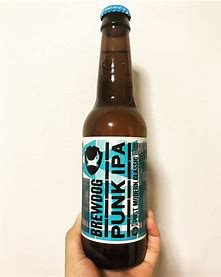

In [44]:
from PIL import Image
label_names = os.listdir(f'scraping/data/folders') # classes
leffe = Image.open("../../../../leffe.jpg").convert('RGB')
brewdog = Image.open("../../../../brewdog.jpg").convert('RGB')
pietra = Image.open("../../../../pietra.jpg").convert('RGB')
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
#
# Pass the image for preprocessing and the image preprocessed
#
leffe_preprocessed = preprocess(leffe)
brewdog_preprocessed = preprocess(brewdog)
pietra_preprocessed = preprocess(pietra)

#
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
#
batch_img_leffe_tensor = torch.unsqueeze(leffe_preprocessed, 0).to(device)
batch_img_brewdog_tensor = torch.unsqueeze(brewdog_preprocessed, 0).to(device)
batch_img_pietra_tensor = torch.unsqueeze(pietra_preprocessed, 0).to(device)

# Resnet is required to be put in evaluation mode in order
# to do prediction / evaluation
#
my_net.eval()
#
# Get the predictions of image as scores related to how the loaded image
# matches with 1000 ImageNet classes. The variable, out is a vector of 1000 scores
#
out_leffe = my_net(batch_img_leffe_tensor)
out_brewdog = my_net(batch_img_brewdog_tensor)
out_pietra = my_net(batch_img_pietra_tensor)

# Find the index (tensor) corresponding to the maximum score in the out tensor.
# Torch.max function can be used to find the information
#
_, index_leffe = torch.max(out_leffe, 1)
_, index_brewdog = torch.max(out_brewdog, 1)
_, index_pietra = torch.max(out_pietra, 1)

#
# Find the score in terms of percentage by using torch.nn.functional.softmax function
# which normalizes the output to range [0,1] and multiplying by 100
#
percentage_leffe = torch.nn.functional.softmax(out_leffe, dim=1)[0] * 100
percentage_brewdog = torch.nn.functional.softmax(out_brewdog, dim=1)[0] * 100
percentage_pietra = torch.nn.functional.softmax(out_pietra, dim=1)[0] * 100

#
# Print the name along with score of the object identified by the model
#

print(label_names[index_leffe[0]], percentage_leffe[index_leffe[0]].item())
print(label_names[index_brewdog[0]], percentage_brewdog[index_brewdog[0]].item())
print(label_names[index_pietra[0]], percentage_pietra[index_pietra[0]].item())

brewdog

#
# Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
#
#_, indices = torch.sort(out_chimay, descending=True)
#[(labels[idx], percentage_chimay[idx].item()) for idx in indices[0][:5]]

### La même chose sous forme de fonction

In [45]:
from PIL import Image
def test_image(image):
  label_names = os.listdir(f'scraping/data/folders') # classes
  image = Image.open(f"../../../../{image}.jpg").convert('RGB')
  preprocess = transforms.Compose([transforms.Resize(size),
          transforms.ToTensor(),
          transforms.Normalize(mean=mean, std=std)
      ])
  
  preprocessed = preprocess(image)
  
  batch_img_tensor = torch.unsqueeze(preprocessed, 0).to(device)
  
  my_net.eval()
  out = my_net(batch_img_tensor)

  _, index = torch.max(out, 1)
  percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

  print(label_names[index[0]], percentage[index[0]].item())

  image

In [49]:
test_image('brewdog')

BREWDOG 81.20479583740234


# Evaluation des résultats sur l'ensemble de test

In [31]:
my_net.train(False)
loss, accuracy = evaluate(my_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))


Accuracy (test): 82.0%
